<a href="https://colab.research.google.com/github/filipemtz/neuralnets/blob/main/cnn_kaggle_brain_hemorrhage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"filipemtz","key":"92bf56716cfe0769b1565f9e09c56554"}'}

In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets list

ref                                                         title                                              size  lastUpdated          downloadCount  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              237KB  2021-11-02 21:56:08          15053  
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-04-28 17:03:01           9138  
imsparsh/musicnet-dataset                                   MusicNet Dataset                                   22GB  2021-02-18 14:12:19           4061  
dhruvildave/wikibooks-dataset                               Wikibooks Dataset                                   2GB  2021-10-22 10:48:21           3359  
promptcloud/careerbuilder-job-listing-2020                  Careerbuilder Jo

In [4]:
!kaggle datasets download -d vbookshelf/computed-tomography-ct-images

 88% 79.0M/90.2M [00:00<00:00, 152MB/s]
100% 90.2M/90.2M [00:00<00:00, 154MB/s]


In [5]:
!unzip computed-tomography-ct-images.zip -d computed-tomography-ct-images

A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: computed-tomography-ct-images/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/Patients_CT/053/brain/10.jpg  
  inflating: computed-tomography-ct-images/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/Patients_CT/053/brain/11.jpg  
  inflating: computed-tomography-ct-images/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/Patients_CT/053/brain/12.jpg  
  inflating: computed-tomography-ct-images/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/Patients_CT/053/brain/13.jpg  
  inflating: computed-tomography-ct-images/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/Patients_CT/053/brain/14.jpg  
  inflating: computed-tomography-ct-images/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/

In [6]:
import os
from sklearn.model_selection import train_test_split

DATA_PATH = "computed-tomography-ct-images/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/"

patients = [int(d) for d in os.listdir(f"{DATA_PATH}/Patients_CT/")]
train_patients, test_patients = train_test_split(patients)

print(f"num train patients: {len(train_patients)} num test patients: {len(test_patients)}")


num train patients: 61 num test patients: 21


In [7]:
import pandas as pd 

diagnostics = pd.read_csv(f"{DATA_PATH}/hemorrhage_diagnosis.csv")
diagnostics.head()

PatientNumber  SliceNumber  ...  No_Hemorrhage  Fracture_Yes_No
0             49            1  ...              1                0
1             49            2  ...              1                0
2             49            3  ...              1                0
3             49            4  ...              1                0
4             49            5  ...              1                0

[5 rows x 9 columns]

In [8]:
diagnostics[diagnostics['PatientNumber'] == 74]

PatientNumber  SliceNumber  ...  No_Hemorrhage  Fracture_Yes_No
761             74            1  ...              1                0
762             74            2  ...              1                0
763             74            3  ...              1                0
764             74            4  ...              1                0
765             74            5  ...              1                0
766             74            6  ...              1                0
767             74            7  ...              1                0
768             74            8  ...              1                0
769             74            9  ...              1                0
770             74           10  ...              1                0
771             74           11  ...              1                0
772             74           12  ...              0                0
773             74           13  ...              0                0
774             74           14  ...              0                0
775             74           15  ...              0                0
776             74           16  ...              0                0
777             74           17  ...              1                0
778             74           18  ...              0                1
779             74           19  ...              0                1
780             74           20  ...              0                1
781             74           21  ...              0                1
782             74           22  ...              0                1
783             74           23  ...              0                1
784             74           24  ...              0                1
785             74           25  ...              0                0
786             74           26  ...              1                0
787             74           27  ...              1                0
788             74           28  ...              1                0
789             74           29  ...              1                0
790             74           30  ...              1                0
791             74           31  ...              1                0
792             74           32  ...              1                0
793             74           33  ...              1                0

[33 rows x 9 columns]

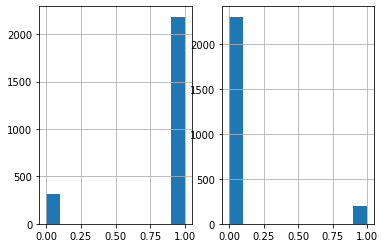

In [9]:
import matplotlib.pyplot as plt

plt.subplot(1, 2, 1)
diagnostics['No_Hemorrhage'].hist()
plt.subplot(1, 2, 2)
diagnostics['Fracture_Yes_No'].hist()



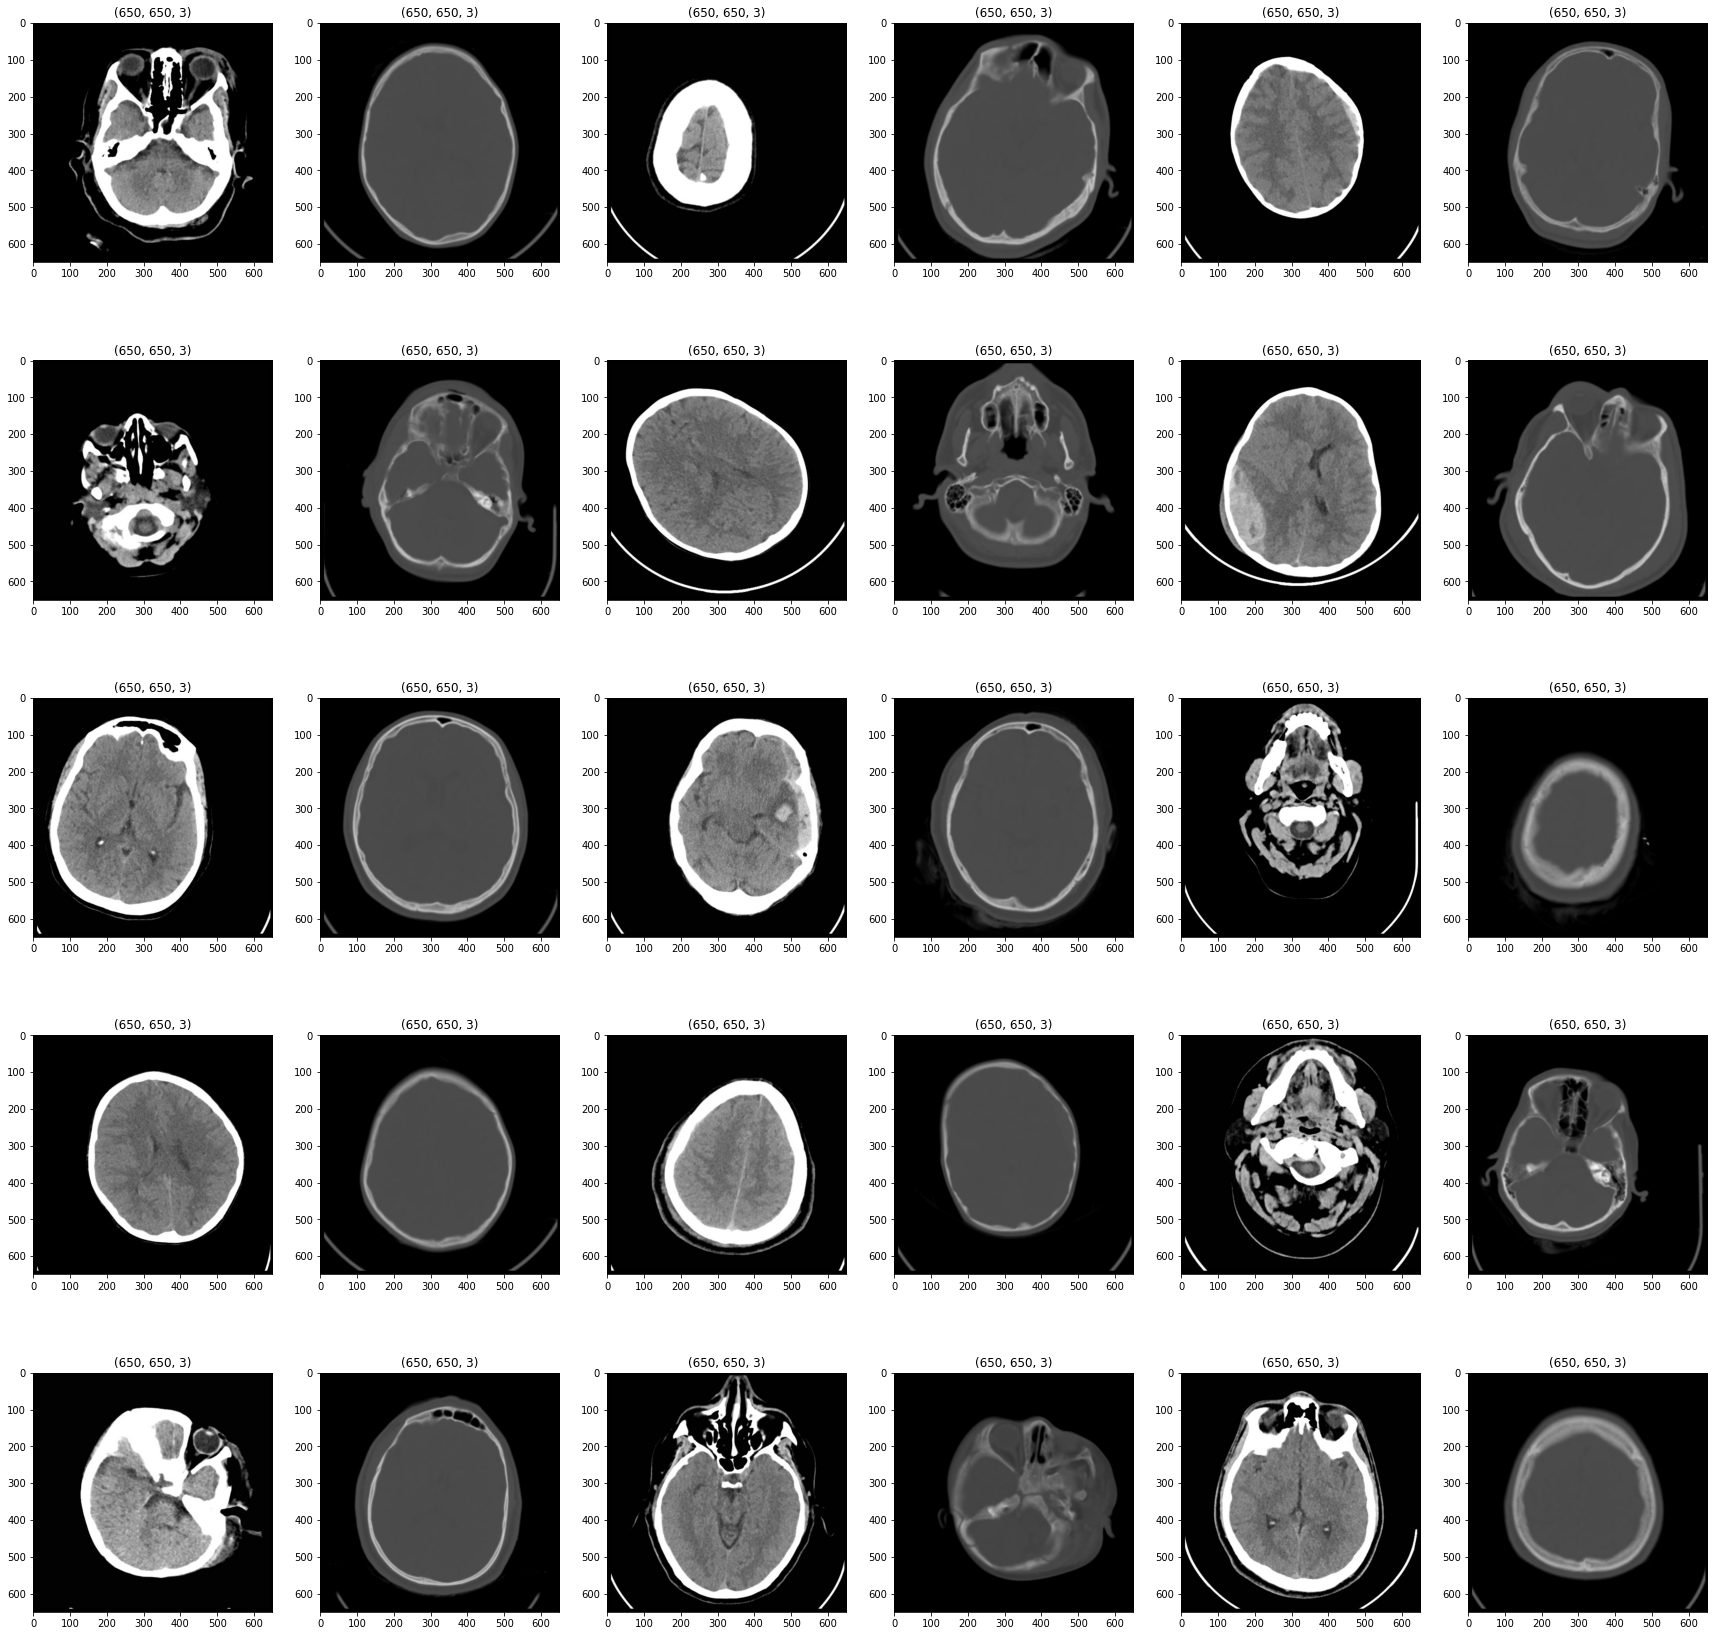

In [10]:
import cv2

data = diagnostics.sample(30)

plt.figure(figsize=(30, 30))
for i in range(5):
  for j in range(6):
    plt.subplot(5, 6, i*6+j+1)
    patient = data.iloc[i*6+j, 0]
    slice_ = data.iloc[i*6+j, 1] 
    if j % 2 == 0:
      window = 'brain'
    else:
      window = 'bone'
    path = f"{DATA_PATH}/Patients_CT/{patient:03d}/{window}/{slice_}.jpg"
    img = cv2.imread(path)
    plt.imshow(img)
    plt.title(f"{img.shape}")


In [11]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import cv2

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode



In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [13]:
print(test_patients)

[86, 110, 124, 127, 125, 57, 50, 84, 115, 59, 123, 97, 102, 65, 122, 63, 53, 62, 126, 89, 101]


In [14]:
class BrainCTDataset(Dataset):
    """Brain CT Dataset."""

    def __init__(self, patients, csv_data, data_dir, is_train, transform=None):
        self.data = []
        for row_id, val in csv_data.iterrows():
          if val.PatientNumber in patients:
            self.data.append([
              val.PatientNumber, 
              val.SliceNumber, 
              val.No_Hemorrhage, 
              val.Fracture_Yes_No
            ])

        if is_train:
          healthy = [d for d in self.data if d[2] == 1] 
          hemorrhage = [d for d in self.data if d[2] == 0] 

          balanced_data = []
          for i in range(len(healthy)):
            balanced_data.append(healthy[i])
            balanced_data.append(hemorrhage[i % len(hemorrhage)])

          self.data = balanced_data
          
        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        p_id, slice_id, hemo_label, frac_label = self.data[idx]
        
        brain_path = f"{self.data_dir}/Patients_CT/{p_id:03d}/brain/{slice_id}.jpg"
        bone_path = f"{self.data_dir}/Patients_CT/{p_id:03d}/bone/{slice_id}.jpg"

        brain_image = cv2.imread(brain_path, cv2.IMREAD_GRAYSCALE)
        bone_image = cv2.imread(bone_path, cv2.IMREAD_GRAYSCALE)

        if brain_image is None:
          print(f'Error loading image {brain_path}. Filling with zeros.')
          brain_image = np.zeros((500, 500), dtype=np.float32)

        if bone_image is None:
          print(f'Error loading image {bone_path}. Filling with zeros.')
          bone_image = np.zeros((500, 500), dtype=np.float32)

        if brain_image.shape[0] != 500 or brain_image.shape[1] != 500:
          brain_image = cv2.resize(brain_image, (500, 500))

        if bone_image.shape[0] != 500 or bone_image.shape[1] != 500:
          bone_image = cv2.resize(bone_image, (500, 500))

        doubled_bone_image = 2 * bone_image.astype(float)
        doubled_bone_image = np.clip(doubled_bone_image, 0, 255)
        doubled_bone_image = doubled_bone_image.astype(np.uint8)

        img = np.dstack([brain_image, bone_image, doubled_bone_image])

        if self.transform:
            img = self.transform(img)

        return img, hemo_label

# https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py
# Olhar AutoAugment no fim da página
train_transforms = transforms.Compose([
  transforms.ToTensor(),
  transforms.Resize([200, 200]),
  #transforms.RandomResizedCrop(size=(200, 200)),
  transforms.RandomHorizontalFlip(),
  transforms.RandomVerticalFlip(),
  transforms.GaussianBlur(kernel_size=3),
  #transforms.RandomPerspective(distortion_scale=0.15, p=0.1),
  transforms.RandomRotation(degrees=20),
])

test_transforms = transforms.Compose([
  transforms.ToTensor(),
  transforms.Resize([200, 200]),
])

train_ds = BrainCTDataset(
    train_patients, 
    diagnostics, 
    DATA_PATH, 
    is_train=True, 
    transform=train_transforms)

test_ds = BrainCTDataset(
    test_patients, 
    diagnostics, 
    DATA_PATH, 
    is_train=False,
    transform=test_transforms)

train_data = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=2)
test_data = DataLoader(test_ds, batch_size=64, shuffle=False, num_workers=2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

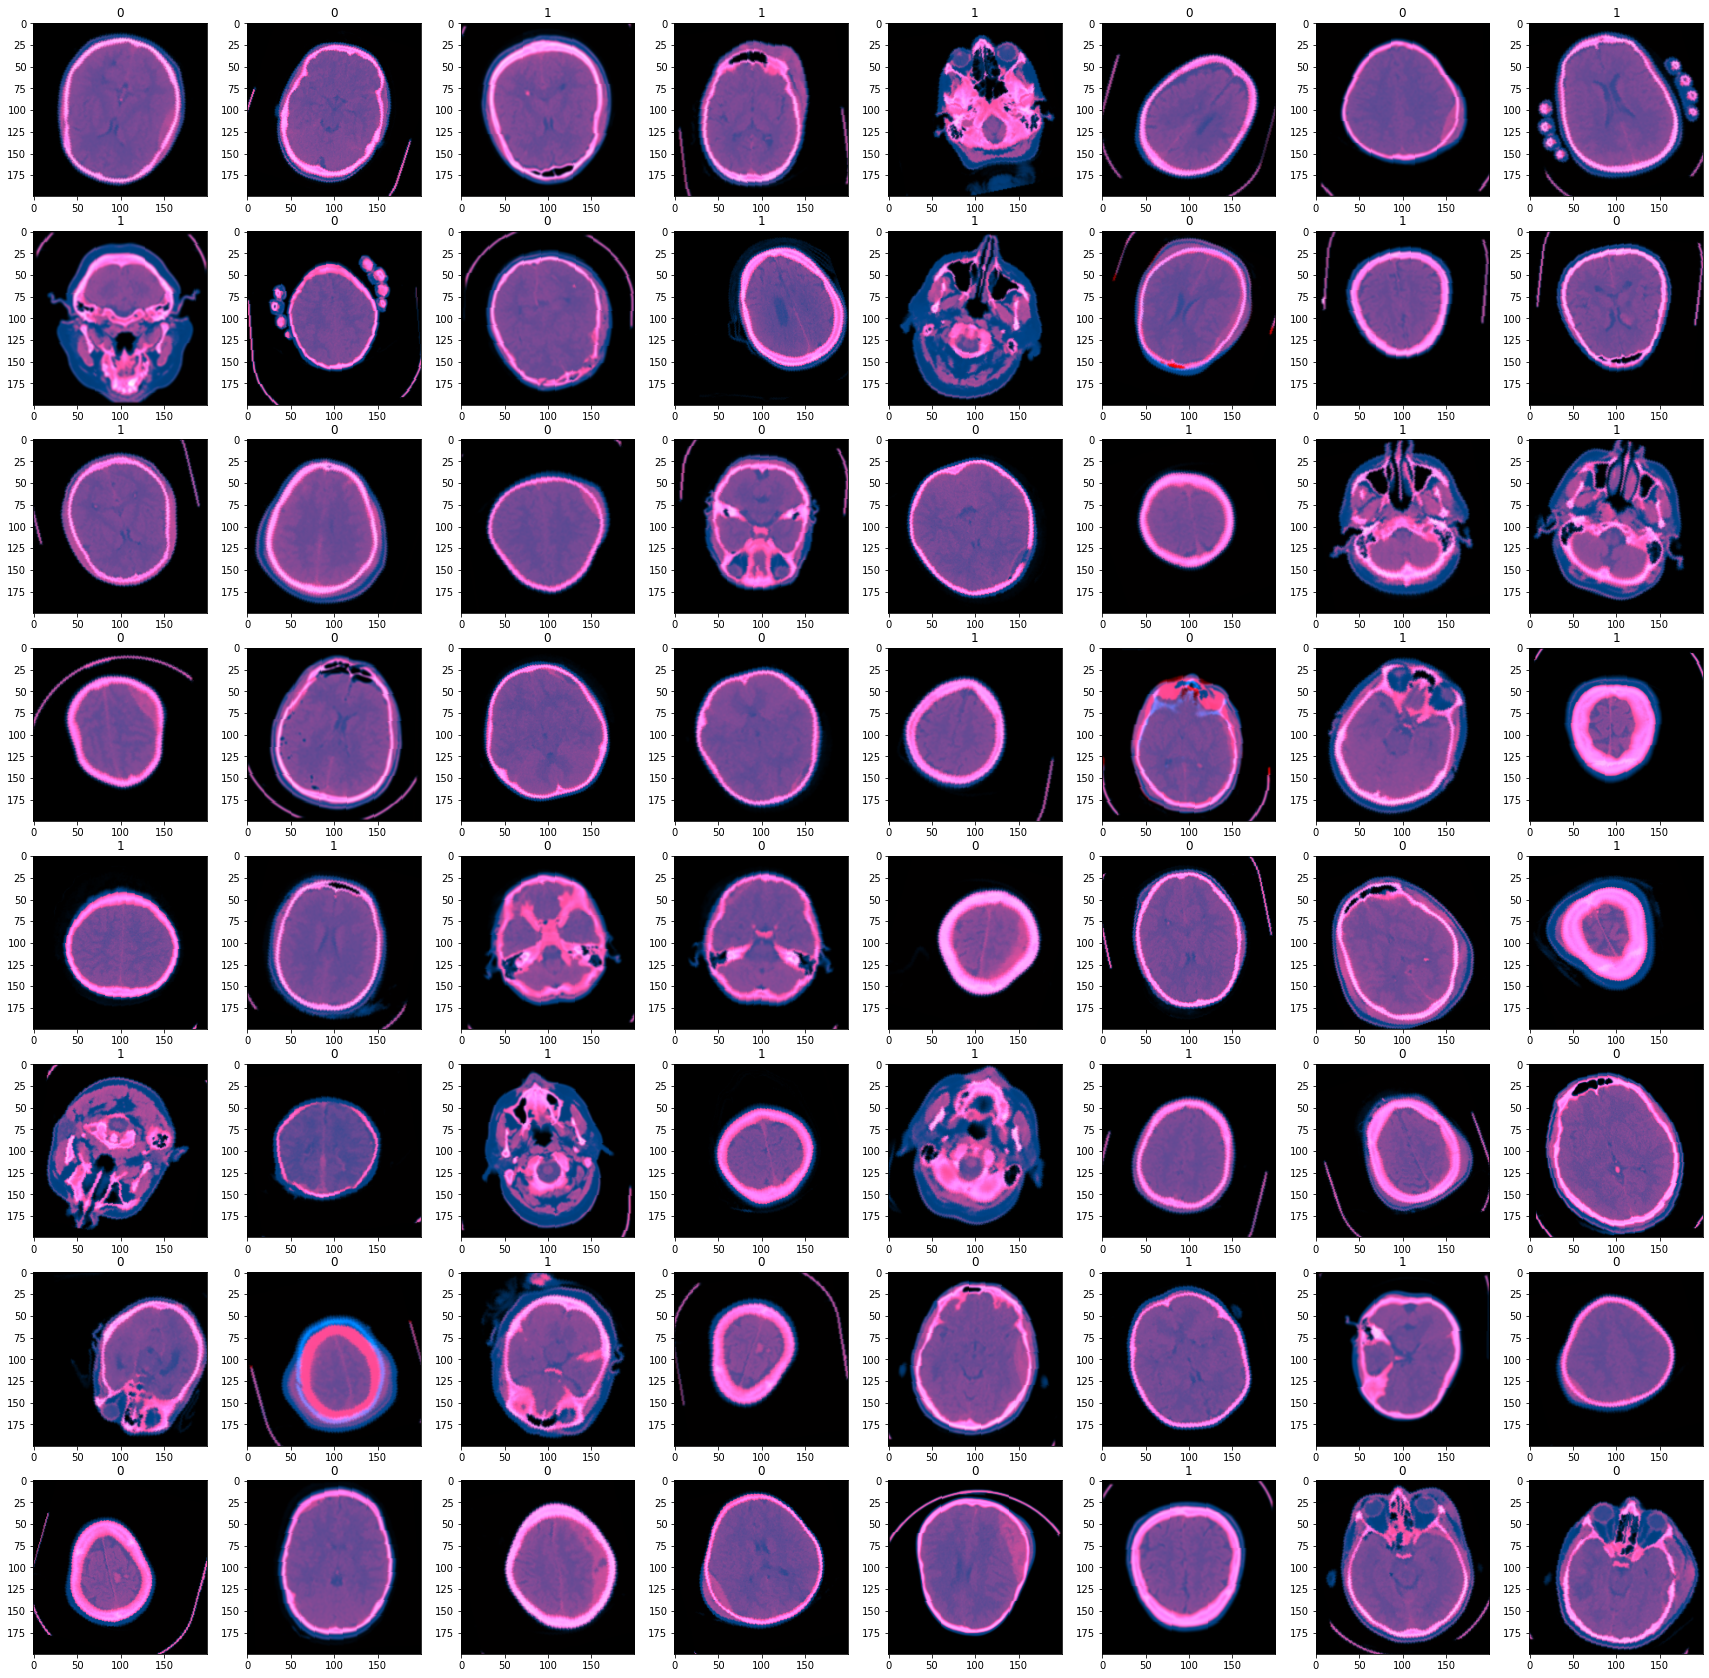

In [15]:
imgs, hemos = next(iter(train_data))

plt.figure(figsize=(30, 30))
for i, (img, label) in enumerate(zip(imgs, hemos)):
  plt.subplot(8, 8, i+1)
  img = img.numpy().transpose(1, 2, 0)
  plt.imshow(img)
  plt.title(f"{label}")


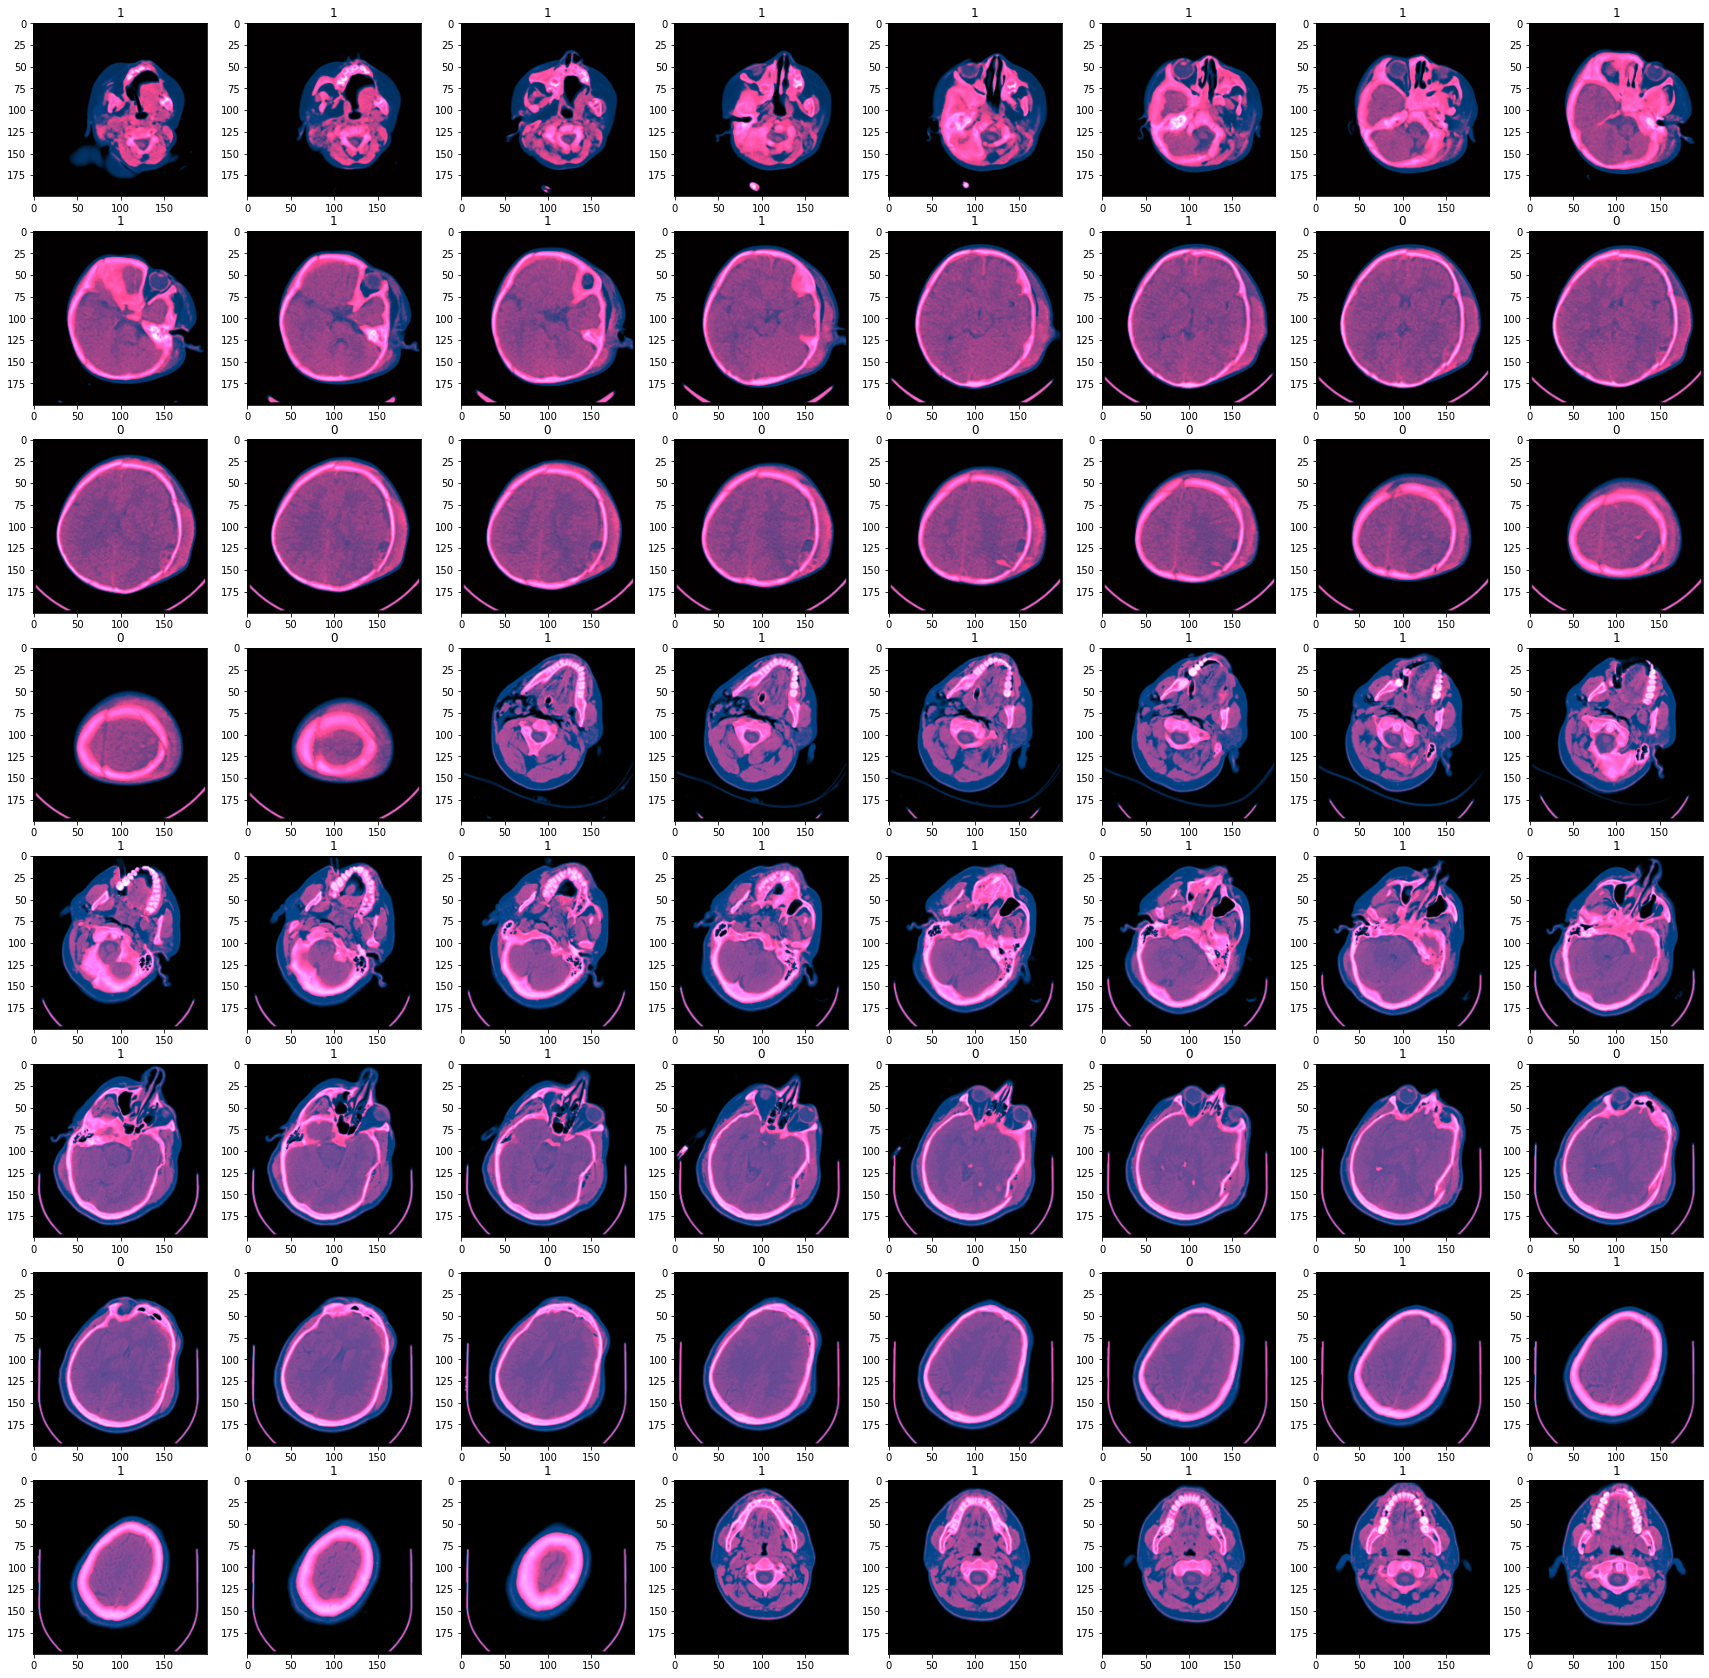

In [16]:
imgs, hemos = next(iter(test_data))

plt.figure(figsize=(30, 30))
for i, (img, label) in enumerate(zip(imgs, hemos)):
  plt.subplot(8, 8, i+1)
  img = img.numpy().transpose(1, 2, 0)
  plt.imshow(img)
  plt.title(f"{label}")



In [17]:
from torchvision import datasets, models

class SimpleCnn(nn.Module):
  def __init__(self):
    super(SimpleCnn, self).__init__()
    self.model = nn.Sequential(
      nn.Conv2d(3, 32, 3, 1),
      nn.MaxPool2d(2),
      nn.ReLU(),
      nn.Conv2d(32, 32, 3, 1),
      nn.MaxPool2d(2),
      nn.ReLU(),
      nn.Conv2d(32, 32, 3, 2),
      nn.MaxPool2d(2),
      nn.ReLU(),
      #nn.Dropout2d(0.25),
      nn.Flatten(),
      nn.Linear(7744, 256),
      nn.ReLU(),
      nn.Linear(256, 256),
      nn.ReLU(),
      nn.Linear(256, 2),
    )

  def forward(self, img):
    return self.model(img)


#net = SimpleCnn()
#print(net)
#net = net.to(device)

net = models.resnet18(pretrained=True)
num_ftrs = net.fc.in_features
net.fc = nn.Linear(num_ftrs, 2)
net = net.to(device)




Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [18]:
loss_fn = nn.CrossEntropyLoss(reduction='sum')
optimizer = optim.Adam(net.parameters(), lr=0.0001)
num_epochs = 20

from sklearn.metrics import confusion_matrix

In [19]:
from tqdm import tqdm 

train_losses, train_hemo_accuracies = [], []
val_losses, val_hemo_accuracies = [], []

best_val_acc = 0

# train loop
for epoch in range(num_epochs):
  train_loss = 0
  train_hemo_hits = 0

  net.train()
  preds = []
  trues = []

  for batch_idx, (img, label) in tqdm(enumerate(train_data)):
    img = img.to(device)
    label = label.to(device)
    optimizer.zero_grad() # reinitialize gradients
    logits = net(img)
    loss = loss_fn(logits, label)
    loss.backward()  # compute gradients in a backward pass
    optimizer.step()  # update weights
    train_loss += loss
    train_hemo_hits += torch.sum(torch.argmax(logits, dim=1) == label.data)
    trues += list(label.cpu().numpy())
    preds += list(np.argmax(logits.cpu().detach().numpy(), axis=-1))

  train_loss /= len(train_ds)
  train_hemo_acc = train_hemo_hits / len(train_ds)
  train_losses.append(train_loss)
  train_hemo_accuracies.append(train_hemo_acc)

  val_loss = 0
  val_hemo_hits = 0
  val_frac_hits = 0
  val_preds = []
  val_trues = []

  net.eval()
  with torch.no_grad():
    for batch_idx, (img, label) in tqdm(enumerate(test_data)):
      img = img.to(device)
      label = label.to(device)
      logits = net(img)
      loss = loss_fn(logits, label)
      val_loss += loss
      val_hemo_hits += torch.sum(torch.argmax(logits, dim=1) == label.data)
      val_trues += list(label.cpu().numpy())
      val_preds += list(np.argmax(logits.cpu().detach().numpy(), axis=-1))


  val_loss /= len(test_ds)
  val_losses.append(val_loss)
  val_hemo_acc = val_hemo_hits / len(test_ds)
  val_hemo_accuracies.append(val_hemo_acc)

  if val_hemo_acc > best_val_acc:
    torch.save(net, "best.pt")
    print("Saved best accuracy model.")
    best_val_acc = val_hemo_acc

  print(f"epoch: {epoch} loss: {train_loss:.3f} hemo_acc: {train_hemo_acc:.3f} val_loss: {val_loss:.3f} val_hemo_acc: {val_hemo_acc:.3f}")
  
  print("train confusion matrix:")
  print(confusion_matrix(trues, preds))

  print("val confusion matrix:")
  print(confusion_matrix(val_trues, val_preds))

  print("----------------\n")

  

50it [00:44,  1.12it/s]
2it [00:01,  1.66it/s]

Error loading image computed-tomography-ct-images/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0//Patients_CT/084/bone/36.jpg. Filling with zeros.


11it [00:06,  1.81it/s]


Saved best accuracy model.
epoch: 0 loss: 0.355 hemo_acc: 0.830 val_loss: 0.678 val_hemo_acc: 0.764
train confusion matrix:
[[1347  224]
 [ 309 1262]]
val confusion matrix:
[[ 50   0]
 [156 456]]
----------------



50it [00:44,  1.12it/s]
2it [00:01,  1.64it/s]

Error loading image computed-tomography-ct-images/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0//Patients_CT/084/bone/36.jpg. Filling with zeros.


11it [00:06,  1.83it/s]


Saved best accuracy model.
epoch: 1 loss: 0.228 hemo_acc: 0.906 val_loss: 0.259 val_hemo_acc: 0.900
train confusion matrix:
[[1455  116]
 [ 180 1391]]
val confusion matrix:
[[ 35  15]
 [ 51 561]]
----------------



50it [00:44,  1.12it/s]
2it [00:01,  1.67it/s]

Error loading image computed-tomography-ct-images/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0//Patients_CT/084/bone/36.jpg. Filling with zeros.


11it [00:06,  1.82it/s]


Saved best accuracy model.
epoch: 2 loss: 0.181 hemo_acc: 0.925 val_loss: 0.170 val_hemo_acc: 0.931
train confusion matrix:
[[1475   96]
 [ 139 1432]]
val confusion matrix:
[[ 35  15]
 [ 31 581]]
----------------



50it [00:44,  1.12it/s]
2it [00:01,  1.65it/s]

Error loading image computed-tomography-ct-images/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0//Patients_CT/084/bone/36.jpg. Filling with zeros.


11it [00:06,  1.82it/s]

epoch: 3 loss: 0.139 hemo_acc: 0.947 val_loss: 0.462 val_hemo_acc: 0.834
train confusion matrix:
[[1514   57]
 [ 110 1461]]
val confusion matrix:
[[ 48   2]
 [108 504]]
----------------




50it [00:44,  1.12it/s]
2it [00:01,  1.70it/s]

Error loading image computed-tomography-ct-images/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0//Patients_CT/084/bone/36.jpg. Filling with zeros.


11it [00:05,  1.85it/s]


Saved best accuracy model.
epoch: 4 loss: 0.116 hemo_acc: 0.957 val_loss: 0.168 val_hemo_acc: 0.947
train confusion matrix:
[[1517   54]
 [  82 1489]]
val confusion matrix:
[[ 32  18]
 [ 17 595]]
----------------



50it [00:44,  1.11it/s]
2it [00:01,  1.70it/s]

Error loading image computed-tomography-ct-images/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0//Patients_CT/084/bone/36.jpg. Filling with zeros.


11it [00:05,  1.84it/s]

epoch: 5 loss: 0.084 hemo_acc: 0.971 val_loss: 0.191 val_hemo_acc: 0.924
train confusion matrix:
[[1539   32]
 [  60 1511]]
val confusion matrix:
[[ 34  16]
 [ 34 578]]
----------------




50it [00:44,  1.11it/s]
2it [00:01,  1.71it/s]

Error loading image computed-tomography-ct-images/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0//Patients_CT/084/bone/36.jpg. Filling with zeros.


11it [00:06,  1.82it/s]

epoch: 6 loss: 0.069 hemo_acc: 0.974 val_loss: 0.446 val_hemo_acc: 0.858
train confusion matrix:
[[1535   36]
 [  47 1524]]
val confusion matrix:
[[ 38  12]
 [ 82 530]]
----------------




50it [00:44,  1.11it/s]
2it [00:01,  1.70it/s]

Error loading image computed-tomography-ct-images/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0//Patients_CT/084/bone/36.jpg. Filling with zeros.


11it [00:05,  1.87it/s]

epoch: 7 loss: 0.084 hemo_acc: 0.969 val_loss: 0.203 val_hemo_acc: 0.940
train confusion matrix:
[[1530   41]
 [  57 1514]]
val confusion matrix:
[[ 34  16]
 [ 24 588]]
----------------




50it [00:44,  1.12it/s]
2it [00:01,  1.72it/s]

Error loading image computed-tomography-ct-images/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0//Patients_CT/084/bone/36.jpg. Filling with zeros.


11it [00:06,  1.83it/s]

epoch: 8 loss: 0.071 hemo_acc: 0.974 val_loss: 0.189 val_hemo_acc: 0.932
train confusion matrix:
[[1538   33]
 [  50 1521]]
val confusion matrix:
[[ 32  18]
 [ 27 585]]
----------------




50it [00:44,  1.11it/s]
2it [00:01,  1.80it/s]

Error loading image computed-tomography-ct-images/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0//Patients_CT/084/bone/36.jpg. Filling with zeros.


11it [00:05,  1.85it/s]

epoch: 9 loss: 0.067 hemo_acc: 0.975 val_loss: 0.224 val_hemo_acc: 0.935
train confusion matrix:
[[1546   25]
 [  53 1518]]
val confusion matrix:
[[ 37  13]
 [ 30 582]]
----------------




50it [00:45,  1.10it/s]
2it [00:01,  1.72it/s]

Error loading image computed-tomography-ct-images/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0//Patients_CT/084/bone/36.jpg. Filling with zeros.


11it [00:06,  1.83it/s]

epoch: 10 loss: 0.050 hemo_acc: 0.980 val_loss: 0.255 val_hemo_acc: 0.937
train confusion matrix:
[[1543   28]
 [  36 1535]]
val confusion matrix:
[[ 38  12]
 [ 30 582]]
----------------




50it [00:44,  1.12it/s]
2it [00:01,  1.71it/s]

Error loading image computed-tomography-ct-images/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0//Patients_CT/084/bone/36.jpg. Filling with zeros.


11it [00:06,  1.82it/s]

Saved best accuracy model.
epoch: 11 loss: 0.047 hemo_acc: 0.986 val_loss: 0.225 val_hemo_acc: 0.949
train confusion matrix:
[[1555   16]
 [  29 1542]]
val confusion matrix:
[[ 37  13]
 [ 21 591]]
----------------




50it [00:44,  1.11it/s]
2it [00:01,  1.72it/s]

Error loading image computed-tomography-ct-images/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0//Patients_CT/084/bone/36.jpg. Filling with zeros.


11it [00:05,  1.85it/s]

epoch: 12 loss: 0.041 hemo_acc: 0.986 val_loss: 0.202 val_hemo_acc: 0.934
train confusion matrix:
[[1553   18]
 [  26 1545]]
val confusion matrix:
[[ 35  15]
 [ 29 583]]
----------------




50it [00:44,  1.12it/s]
2it [00:01,  1.73it/s]

Error loading image computed-tomography-ct-images/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0//Patients_CT/084/bone/36.jpg. Filling with zeros.


11it [00:06,  1.83it/s]


epoch: 13 loss: 0.044 hemo_acc: 0.981 val_loss: 0.233 val_hemo_acc: 0.929
train confusion matrix:
[[1540   31]
 [  28 1543]]
val confusion matrix:
[[ 35  15]
 [ 32 580]]
----------------



50it [00:44,  1.13it/s]
2it [00:01,  1.75it/s]

Error loading image computed-tomography-ct-images/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0//Patients_CT/084/bone/36.jpg. Filling with zeros.


11it [00:05,  1.87it/s]


Saved best accuracy model.
epoch: 14 loss: 0.040 hemo_acc: 0.986 val_loss: 0.201 val_hemo_acc: 0.955
train confusion matrix:
[[1551   20]
 [  25 1546]]
val confusion matrix:
[[ 35  15]
 [ 15 597]]
----------------



50it [00:44,  1.13it/s]
2it [00:01,  1.72it/s]

Error loading image computed-tomography-ct-images/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0//Patients_CT/084/bone/36.jpg. Filling with zeros.


11it [00:05,  1.85it/s]

epoch: 15 loss: 0.031 hemo_acc: 0.992 val_loss: 0.246 val_hemo_acc: 0.950
train confusion matrix:
[[1560   11]
 [  14 1557]]
val confusion matrix:
[[ 32  18]
 [ 15 597]]
----------------




50it [00:44,  1.13it/s]
2it [00:01,  1.77it/s]

Error loading image computed-tomography-ct-images/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0//Patients_CT/084/bone/36.jpg. Filling with zeros.


11it [00:05,  1.84it/s]

epoch: 16 loss: 0.028 hemo_acc: 0.991 val_loss: 0.345 val_hemo_acc: 0.932
train confusion matrix:
[[1559   12]
 [  16 1555]]
val confusion matrix:
[[ 36  14]
 [ 31 581]]
----------------




50it [00:43,  1.14it/s]
2it [00:01,  1.75it/s]

Error loading image computed-tomography-ct-images/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0//Patients_CT/084/bone/36.jpg. Filling with zeros.


11it [00:05,  1.84it/s]

epoch: 17 loss: 0.027 hemo_acc: 0.990 val_loss: 0.370 val_hemo_acc: 0.912
train confusion matrix:
[[1555   16]
 [  16 1555]]
val confusion matrix:
[[ 44   6]
 [ 52 560]]
----------------




50it [00:45,  1.10it/s]
2it [00:01,  1.72it/s]

Error loading image computed-tomography-ct-images/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0//Patients_CT/084/bone/36.jpg. Filling with zeros.


11it [00:06,  1.80it/s]

epoch: 18 loss: 0.031 hemo_acc: 0.989 val_loss: 0.244 val_hemo_acc: 0.955
train confusion matrix:
[[1558   13]
 [  21 1550]]
val confusion matrix:
[[ 31  19]
 [ 11 601]]
----------------




50it [00:46,  1.08it/s]
2it [00:01,  1.65it/s]

Error loading image computed-tomography-ct-images/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0//Patients_CT/084/bone/36.jpg. Filling with zeros.


11it [00:06,  1.74it/s]

epoch: 19 loss: 0.019 hemo_acc: 0.995 val_loss: 0.331 val_hemo_acc: 0.935
train confusion matrix:
[[1566    5]
 [  12 1559]]
val confusion matrix:
[[ 26  24]
 [ 19 593]]
----------------



Text(0.5, 1.0, 'hemo accuracy')

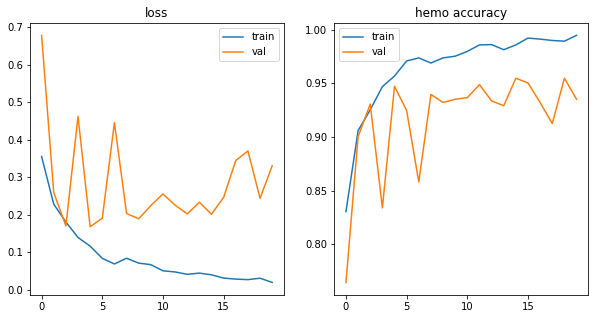

In [20]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.legend()
plt.title("loss")

plt.subplot(1, 2, 2)
plt.plot(train_hemo_accuracies, label='train')
plt.plot(val_hemo_accuracies, label='val')
plt.legend()
plt.title("hemo accuracy")



In [21]:
pred_hemo = []
true_hemo = []

net.eval()

with torch.no_grad():
  for batch_idx, (img, label) in enumerate(test_data):
    img = img.to(device)
    logits = net(img)
    logits = logits.to('cpu')
    
    pred_hemo += list(torch.argmax(logits, dim=1).numpy())
    true_hemo += list(label.numpy())
    
print("OK!")

Error loading image computed-tomography-ct-images/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0//Patients_CT/084/bone/36.jpg. Filling with zeros.
OK!


In [22]:
from sklearn.metrics import confusion_matrix

print("CONFUSION MATRIX HEMO:")
print(confusion_matrix(true_hemo, pred_hemo))


CONFUSION MATRIX HEMO:
[[ 26  24]
 [ 19 593]]


In [23]:
from sklearn.metrics import classification_report

print("CLASSIFICATION REPORT HEMO:")
print(classification_report(true_hemo, pred_hemo))



CLASSIFICATION REPORT HEMO:
              precision    recall  f1-score   support

           0       0.58      0.52      0.55        50
           1       0.96      0.97      0.97       612

    accuracy                           0.94       662
   macro avg       0.77      0.74      0.76       662
weighted avg       0.93      0.94      0.93       662



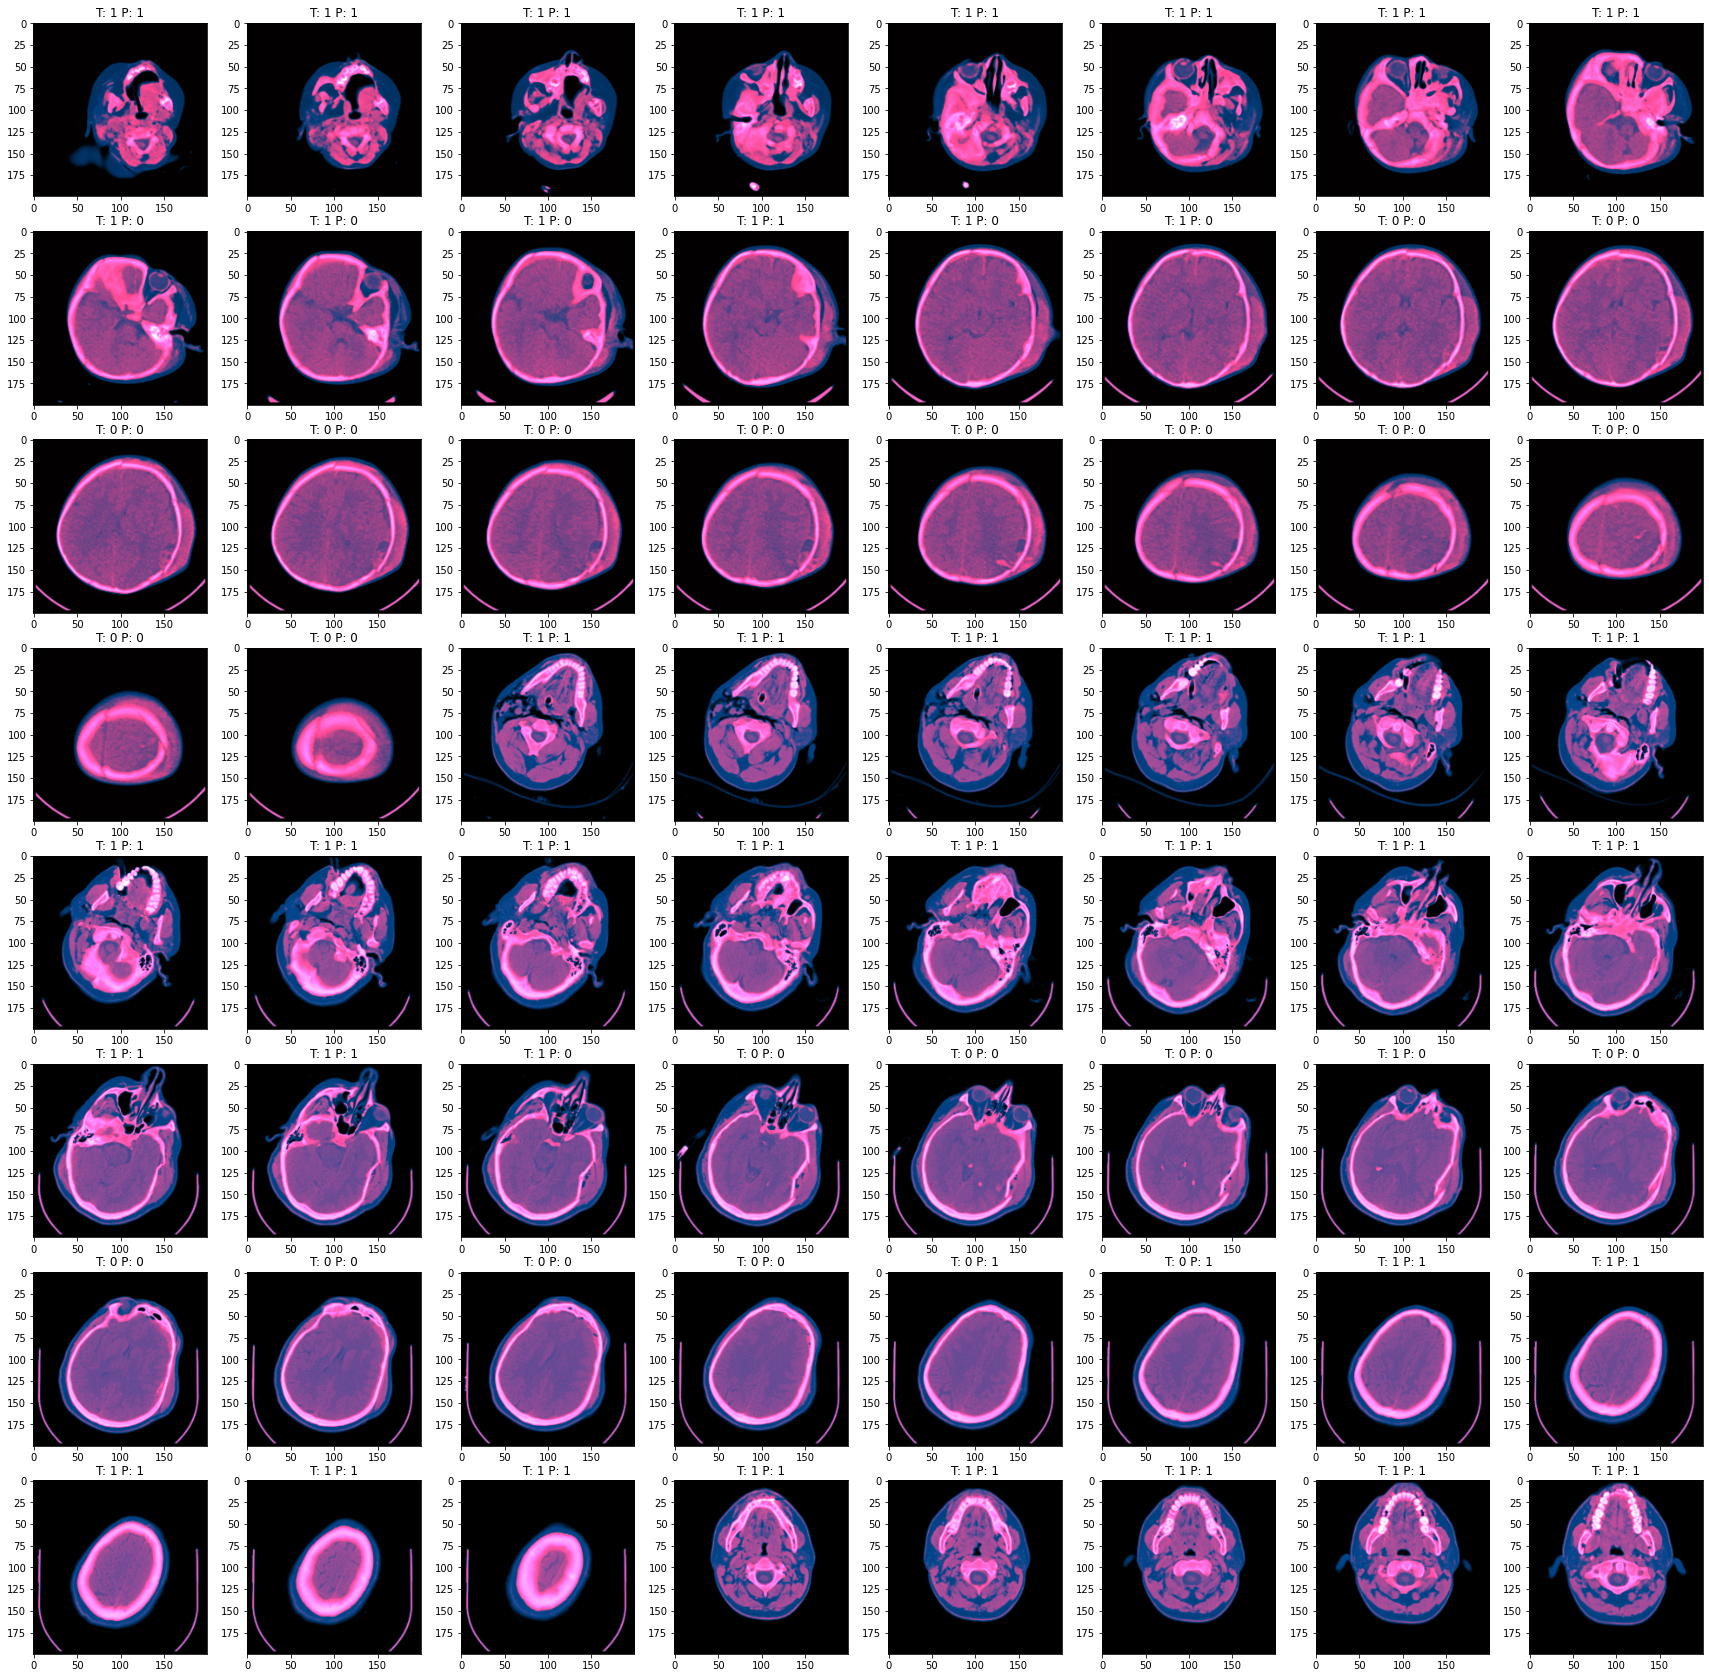

In [24]:

imgs, labels = next(iter(test_data))
imgs = imgs.to(device)

net.eval()
with torch.no_grad():
  preds = net(imgs)


plt.figure(figsize=(30, 30))
for i, (img, label, pred) in enumerate(zip(imgs, labels, preds)):
  plt.subplot(8, 8, i+1)
  img = img.cpu().numpy().transpose(1, 2, 0)
  plt.imshow(img)
  plt.title(f"T: {label} P: {torch.argmax(pred, dim=0).cpu().numpy()}")

In [25]:
torch.save(net, "model.pt")


In [26]:
files.download('model.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>